In [27]:
import numpy as np
import matplotlib.pyplot as plt
from multiprocessing import Pool
from functools import partial

In [28]:
## setting up the range and the field of view (FOV)
N = 1500
FOV = 5e-4
x = np.linspace(0,FOV,N)
sample_rate = x[2] - x[1]

wavelength = 532e-9

In [29]:
## Calculating the k-values to plot the transform against
kvalues = np.empty(N)

if N % 2 == 0:
    kvaluesoriginal = np.linspace(-N/2,(N/2)-1,N)/(sample_rate*N)
else:
    kvaluesoriginal = np.linspace(-(N-1)/2,(N-1)/2,N)/(sample_rate*N)
newN = int(N/2)
if N % 2 == 0:
    kvalues[0:newN] = kvaluesoriginal[newN:N]
    kvalues[newN:N] = kvaluesoriginal[0:newN]
if N % 2 != 0:
    kvalues[0:newN+1] = kvaluesoriginal[newN:N]
    kvalues[newN+1:N] = kvaluesoriginal[0:newN]

In [30]:
## Setting up the reflectivity as a function of x. This is what we'll be taking the transform of.
Reflectivity = np.ones(N)/2
# Reflectivity = Reflectivity/2
Reflectivity[int(np.floor(3*N/7)):int(np.ceil(4*N/7))] = 1
# Reflectivity[int(np.floor(7*N/14)):int(np.floor(8*N/14))] = 0.8
Object = Reflectivity*FOV

## Calling and defining the transform and inverse using the built-in functions.
fftf = np.fft.fft(Reflectivity)
ifftf = np.fft.ifft(fftf)
k = np.fft.fftfreq(N,sample_rate)
kf = kvalues

## Here to the end of the cell is going through the transform and inverse by hand w/ the "shadow function"
newx = np.arange(0,N,1)
OneD_transform = np.empty(N,dtype=np.complex)
OneD_inverse_transform = np.empty(N,dtype=np.complex)
OneD_forward_integrand = np.empty(N,dtype=np.complex)
OneD_backward_integrand = np.empty(N,dtype=np.complex)
deltak = 1/FOV
tolerance = 1e-10
h = np.diff(Object)
h[abs(h) < tolerance] = 0.0

for n in range(0,N):
    shadow_function = np.ones(N)
    if n > 0:
        theta = 2*np.arcsin(n*wavelength*deltak/2)
        d = h*np.tan(theta/2)
        for i in np.where(h != 0)[0]:
            dindex = int(np.floor(d[[i]]/sample_rate))
            if h[i] > 0:
                shadow_function[max(0,i-dindex):i+1] = 0.0
            if h[i] < 0:
                shadow_function[i:min(N,i-dindex)] = 0.0
    OneD_forward_integrand = Reflectivity*np.exp(n*(-1j)*newx*2*np.pi/N)*shadow_function
    OneD_transform[n] = sum(OneD_forward_integrand)
    

OneD_transform.real[abs(OneD_transform.real) < tolerance] = 0.0
OneD_transform.imag[abs(OneD_transform.imag) < tolerance] = 0.0

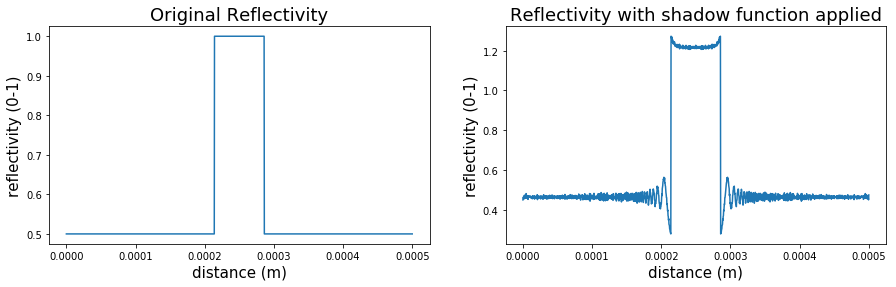

In [31]:
plt.subplots(figsize=(15,4))
plt.subplot(1,2,1)
plt.title("Original Reflectivity", fontsize=18)
plt.xlabel("distance (m)", fontsize=15)
plt.ylabel("reflectivity (0-1)", fontsize=15)
plt.plot(x,Reflectivity)

plt.subplot(1,2,2)
plt.title("Reflectivity with shadow function applied", fontsize=18)
plt.xlabel("distance (m)", fontsize=15)
plt.ylabel("reflectivity (0-1)", fontsize=15)
plt.plot(x,np.fft.ifft((OneD_transform)).real)
plt.show()

In [32]:
type(OneD_transform)

numpy.ndarray

In [6]:
def forward_transform_with_shadow(object_array, reflectivity_array, field_of_view, wavelength):
    Object = object_array
    Reflectivity = reflectivity_array
    N = np.size(Reflectivity)
    FOV = field_of_view
    l = wavelength
    x = np.linspace(0,FOV,N)
    sample_rate = x[2] - x[1]
    
    ## Here to the end of the cell is going through the transform and inverse by hand w/ the "shadow function"
    newx = np.arange(0,N,1)
    OneD_transform = np.empty(N,dtype=np.complex)
    OneD_forward_integrand = np.empty(N,dtype=np.complex)
    deltak = 1/FOV
    h = np.diff(Object)
    h[abs(h) < tolerance] = 0.0

    for n in range(0,N):
        shadow_function = np.ones(N)
        if n > 0:
            theta = 2*np.arcsin(n*wavelength*deltak/2)
            d = h*np.tan(theta/2)
            for i in np.where(h != 0)[0]:
                dindex = int(np.floor(d[[i]]/sample_rate))
                if h[i] > 0:
                    shadow_function[max(0,i-dindex):i+1] = 0.0
                if h[i] < 0:
                    shadow_function[i:min(N,i-dindex)] = 0.0
        OneD_forward_integrand = Reflectivity*np.exp(n*(-1j)*newx*2*np.pi/N)*shadow_function
        OneD_transform[n] = sum(OneD_forward_integrand)


    OneD_transform.real[abs(OneD_transform.real) < tolerance] = 0.0
    OneD_transform.imag[abs(OneD_transform.imag) < tolerance] = 0.0
    
    return OneD_transform

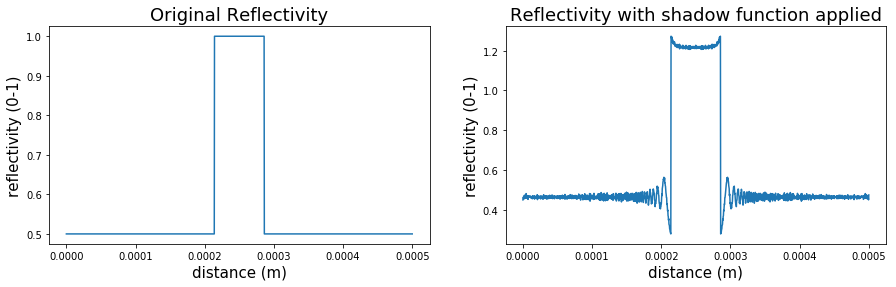

In [7]:
## setting up the range and the field of view (FOV)
N = 1500
FOV = 5e-4
wavelength = 532e-9

## Setting up the reflectivity as a function of x. This is what we'll be taking the transform of.
Reflectivity = np.ones(N)/2
# Reflectivity = Reflectivity/2
Reflectivity[int(np.floor(3*N/7)):int(np.ceil(4*N/7))] = 1
# Reflectivity[int(np.floor(7*N/14)):int(np.floor(8*N/14))] = 0.8
Object = Reflectivity*FOV


IPSII = forward_transform_with_shadow(Object, Reflectivity, FOV, wavelength)


plt.subplots(figsize=(15,4))
plt.subplot(1,2,1)
plt.title("Original Reflectivity", fontsize=18)
plt.xlabel("distance (m)", fontsize=15)
plt.ylabel("reflectivity (0-1)", fontsize=15)
plt.plot(x,Reflectivity)

plt.subplot(1,2,2)
plt.title("Reflectivity with shadow function applied", fontsize=18)
plt.xlabel("distance (m)", fontsize=15)
plt.ylabel("reflectivity (0-1)", fontsize=15)
plt.plot(x,np.fft.ifft((IPSII)).real)
plt.show()

In [21]:
#### THIS IS THE BEST FINAL ONE FOR ONE-D
def forward_transform_with_shadow(n, object_array, reflectivity_array, field_of_view, wavelength):
    Object = object_array
    Reflectivity = reflectivity_array
    N = np.size(Reflectivity)
    FOV = field_of_view
    l = wavelength
    sample_rate = x[2] - x[1]#
    
    ## Here to the end of the cell is going through the transform and inverse by hand w/ the "shadow function"
    newx = np.arange(0,N,1)
    OneD_transform = np.empty(N,dtype=np.complex)
    OneD_forward_integrand = np.empty(N,dtype=np.complex)
    deltak = 1/FOV
    h = np.diff(Object)
    tolerance = 1e-10
    h[abs(h) < tolerance] = 0.0

    
    shadow_function = np.ones(N)
    if n > 0:
        theta = 2*np.arcsin(n*wavelength*deltak/2)
        d = h*np.tan(theta/2)
        for i in np.where(h != 0)[0]:
            dindex = int(np.floor(d[[i]]/sample_rate))
            if h[i] > 0:
                shadow_function[max(0,i-dindex):i+1] = 0.0
            if h[i] < 0:
                shadow_function[i:min(N,i-dindex)] = 0.0
    OneD_forward_integrand = Reflectivity*np.exp(n*(-1j)*newx*2*np.pi/N)*shadow_function
    OneD_transform = sum(OneD_forward_integrand)

    
    return OneD_transform

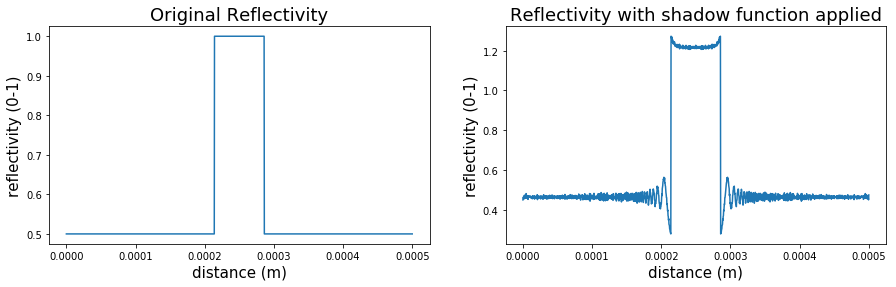

In [26]:
#### THIS IS THE BEST FINAL ONE FOR ONE-D
p = Pool()

## setting up the range and the field of view (FOV)
N = 1500
FOV = 5e-4
x = np.linspace(0,FOV,N)
l = 532e-9

## Setting up the reflectivity as a function of x. This is what we'll be taking the transform of.
Reflectivity = np.ones(N)/2
# Reflectivity = Reflectivity/2
Reflectivity[int(np.floor(3*N/7)):int(np.ceil(4*N/7))] = 1
# Reflectivity[int(np.floor(7*N/14)):int(np.floor(8*N/14))] = 0.8
Object = Reflectivity*FOV


IPSII = p.map(partial(forward_transform_with_shadow, object_array=Object, reflectivity_array=Reflectivity, field_of_view=FOV, wavelength=l),range(N))

tolerance = 1e-10
OneD_transform.real[abs(OneD_transform.real) < tolerance] = 0.0
OneD_transform.imag[abs(OneD_transform.imag) < tolerance] = 0.0



plt.subplots(figsize=(15,4))
plt.subplot(1,2,1)
plt.title("Original Reflectivity", fontsize=18)
plt.xlabel("distance (m)", fontsize=15)
plt.ylabel("reflectivity (0-1)", fontsize=15)
plt.plot(x,Reflectivity)

plt.subplot(1,2,2)
plt.title("Reflectivity with shadow function applied", fontsize=18)
plt.xlabel("distance (m)", fontsize=15)
plt.ylabel("reflectivity (0-1)", fontsize=15)
plt.plot(x,np.fft.ifft((IPSII)).real)
plt.show()

In [20]:
OneD_transform

array([ 858.00000000+0.j        , -103.00353833-0.43146274j,
         92.92566861+0.77851047j, ..., -155.31073504+1.951795j  ,
        187.08701309-1.56737316j, -207.80587139+0.87046029j])

In [12]:
def mult(x, array):
    y = x*array
    return y

p = Pool()

In [13]:
thing = 2
v = np.arange(0,5,1)
p.map(partial(mult,array = v), range(10))

[array([0, 0, 0, 0, 0]),
 array([0, 1, 2, 3, 4]),
 array([0, 2, 4, 6, 8]),
 array([ 0,  3,  6,  9, 12]),
 array([ 0,  4,  8, 12, 16]),
 array([ 0,  5, 10, 15, 20]),
 array([ 0,  6, 12, 18, 24]),
 array([ 0,  7, 14, 21, 28]),
 array([ 0,  8, 16, 24, 32]),
 array([ 0,  9, 18, 27, 36])]

In [101]:

p.map(partial(forward_transform_with_shadow, object_array=Object, reflectivity_array=Reflectivity, field_of_view=FOV, wavelength=wavlength),range(N))
